# Classifying Simpsons characters in images


### TODO
 
* Cut of edges first
* Face analysis to extract face pixels
* Average all the bart images and see what the output is


## Dataset:

Many thanks to [jbencina](https://github.com/jbencina) for making this dataset available. The dataset is available on github [here](https://github.com/jbencina/simpsons-image-training-dataset): 

> Collection of 30,693 frames from 65 Simspsons episodes from seasons 3, 4, and 5. Each image is **160x120** pixels.
> 
> One collection (faces-clean-color) contains isolated frames of Homer (n=1,041), Marge (n=444), Lisa (n=358), and Bart (n=645) totalling (n=2,488). These files are labled as {instance_number}_{character_name}.jpg. 
> 
> The second collection (unsorted-color) contains 28,205 unsorted frames which can contain backgrounds, characters, text, etc. The two sets are mutually exclusive. This has been broken up into several archives for upload.

This basically gives us 2488 images to train a Simpsons-classifier-model on. Here we go!


1071 Example of an image where it thinks it's marge but it's actually homer. Main reason is probably the blue background. This causes it to think it's marges hair.

In [2]:
from scipy import misc
from scipy.ndimage import find_objects,label

import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd

from os import listdir
from os.path import isfile, join

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

Getting the list of images. I took out 120 images (30 of each character) from the labeled dataset and moved it to a test folder. I'll use this to test my model and see how well it classifies. 

In [115]:
image_path = "c:/projects/simpsons/faces"
image_path_test = "c:/projects/simpsons/faces_test"

image_list = [f for f in listdir(image_path) if isfile(join(image_path, f))]
image_list_test = [f for f in listdir(image_path_test) if isfile(join(image_path_test, f))]

Using regex to extract the target values from the file names. 

In [116]:
regex_pat = '_([a-z]+).jpg'

target_array = np.array([re.findall(regex_pat,f)[0] for f in image_list])
target_array_test = np.array([re.findall(regex_pat,f)[0] for f in image_list_test])

In [160]:
name_list, name_list_counts = np.unique(target_array, return_counts=True)

### Lesson 1 learned

One of my initial models had a strong bias towards predicting Bart and Homer while at the same time Lisa was not getting predicted as often as she should. Turns out the amount of input images was skewed. There were many more Homers and Barts then Lisa's. 

I then tried 'limiting' the input images to the minimum number. The character with the least amount of labeled images in the dataset is Lisa who has 338 of them. This means that I might have 1041 images of homer but I'm only using 338. The model is being trained on 338 images of Lisa, 338 images of Bart, 338 images of Marge and 338 images of Homer. 

I'm not sure if elimating potential training material is best practice but in this case this did cause the model to improve significantly. 

In [154]:
at_most = min(name_list_counts)

image_list_by_character = []
image_list_filtered = []

for i in name_list:
    image_list_by_character.append([x for x in image_list if x.find(i) > 0])

for i in image_list_by_character:
    image_list_filtered = image_list_filtered+i[0:at_most]
    
image_list_filtered = np.array(image_list_filtered)

Time to read in the actual images from the new `image_list` 

In [158]:
image_array = [misc.imread('faces/' + f).astype(np.uint8) for f in image_list_filtered]
image_array = np.array(image_array)

image_array_test = [misc.imread('faces_test/' + f).astype(np.uint8) for f in image_list_test]
image_array_test = np.array(image_array_test)

Need to recalculate the target array as it needs to have less values now.

In [159]:
target_array = np.array([re.findall(regex_pat,f)[0] for f in image_list_filtered])
target_array_test = np.array([re.findall(regex_pat,f)[0] for f in image_list_test])

Reshaping the image array to the shape [*num_images* , *num_cols*]. In this case the number of images is 1312 in our training set. The number of cols is 57600. 

The images are 120 by 160 pixels. Each image therefore has 19200 pixels. Each pixel is represented by 3 RGB values so each pixel has 3 values by itself. So in total, each image has 57600 columns of data. 

In [162]:
image_array = image_array.reshape((-1, 1, 57600))
image_array_test = image_array_test.reshape((-1, 1, 57600))

In [163]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(image_array[:,0], target_array)
pred = rf.predict(image_array_test[:,0])

In [169]:
print(metrics.classification_report(target_array_test, pred))

             precision    recall  f1-score   support

       bart       0.76      0.83      0.79        30
      homer       0.78      0.83      0.81        30
       lisa       0.85      0.73      0.79        30
      marge       0.93      0.90      0.92        30

avg / total       0.83      0.82      0.83       120



In [170]:
 for i, j in enumerate(pred[0:10]):
     print("Pred: " + j + ", should be " + target_array_test[i] + " " + image_list_test[i])

Pred: bart, should be bart 0_bart.jpg
Pred: bart, should be bart 102_bart.jpg
Pred: marge, should be homer 1071_homer.jpg
Pred: homer, should be homer 1087_homer.jpg
Pred: lisa, should be lisa 1724_lisa.jpg
Pred: lisa, should be lisa 1725_lisa.jpg
Pred: lisa, should be lisa 1726_lisa.jpg
Pred: lisa, should be lisa 1727_lisa.jpg
Pred: lisa, should be lisa 1728_lisa.jpg
Pred: bart, should be lisa 1729_lisa.jpg


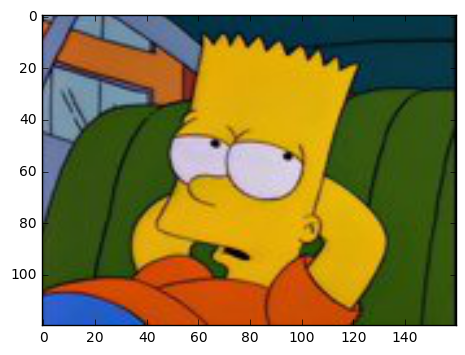

In [166]:
plt.imshow(misc.imread('faces/10_bart.jpg'))
plt.show()

This is me while fitting the model.